<a href="https://colab.research.google.com/github/zachfreitas/ADS_505_Applied_Data_Sci_for_Business-/blob/main/Module_3/Assignment_3/Zachariah_Freitas_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3.1
Zachariah Freitas <br>
2022-09-24

Import required packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 27.9 MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import matplotlib.pylab as plt

from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary, regressionSummary
import dmba

%matplotlib inline

no display found. Using non-interactive Agg backend


## Data ETL and EDA

In [3]:
# Load the data
taxi_df = pd.read_csv('https://raw.githubusercontent.com/zachfreitas/ADS_505_Applied_Data_Sci_for_Business-/main/Module_3/Assignment_3/Taxi-cancellation-case.csv')
taxi_df.head()

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,1,17712,12,NaN,2,1021.0,1323.0,NaN,NaN,1/1/13 22:33,NaN,0,0,1/1/13 8:01,13.028530,77.54625,12.869805,77.653211,0
1,2,17037,12,NaN,2,455.0,1330.0,NaN,NaN,1/1/13 12:43,NaN,0,0,1/1/13 9:59,12.999874,77.67812,12.953434,77.706510,0
2,3,761,12,NaN,2,814.0,393.0,NaN,NaN,1/2/13 0:28,1/3/13 0:00,1,0,1/1/13 12:14,12.908993,77.68890,13.199560,77.706880,0
3,4,868,12,NaN,2,297.0,212.0,NaN,NaN,1/1/13 13:12,NaN,0,0,1/1/13 12:42,12.997890,77.61488,12.994740,77.607970,0
4,5,21716,28,NaN,2,1237.0,330.0,NaN,NaN,1/1/13 16:33,NaN,0,0,1/1/13 15:07,12.926450,77.61206,12.858833,77.589127,0


In [4]:
# Convert from/to lat/longs to a destination distance in kilometers.
import numpy as np

def haversine_vectorize(lon1, lat1, lon2, lat2):
  
  lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

  newlon = lon2 - lon1
  newlat = lat2 - lat1

  haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

  dist = 2 * np.arcsin(np.sqrt(haver_formula ))
  km = 6367 * dist #6367 for distance in KM for miles use 3958
  return km

taxi_df['dist(km)'] = haversine_vectorize(taxi_df['from_long'],taxi_df['from_lat'],taxi_df['to_long'],taxi_df['to_lat'])

In [5]:
# Adjust DTypes
def cat_types(df, columnName):
  df[columnName] = df[columnName].astype("category")

# List to Apply Function to.
cat_list = ['user_id', 'vehicle_model_id', 'package_id', 'travel_type_id']

# List Comphension
[cat_types(taxi_df, i) for i in cat_list]

[None, None, None, None]

In [6]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   row#                 10000 non-null  int64   
 1   user_id              10000 non-null  category
 2   vehicle_model_id     10000 non-null  category
 3   package_id           1752 non-null   category
 4   travel_type_id       10000 non-null  category
 5   from_area_id         9985 non-null   float64 
 6   to_area_id           7909 non-null   float64 
 7   from_city_id         3706 non-null   float64 
 8   to_city_id           339 non-null    float64 
 9   from_date            10000 non-null  object  
 10  to_date              5822 non-null   object  
 11  online_booking       10000 non-null  int64   
 12  mobile_site_booking  10000 non-null  int64   
 13  booking_created      10000 non-null  object  
 14  from_lat             9985 non-null   float64 
 15  from_long           

In [7]:
taxi_df.head()

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,dist(km)
0,1,17712,12,NaN,2,1021.0,1323.0,NaN,NaN,1/1/13 22:33,NaN,0,0,1/1/13 8:01,13.028530,77.54625,12.869805,77.653211,0,21.102007
1,2,17037,12,NaN,2,455.0,1330.0,NaN,NaN,1/1/13 12:43,NaN,0,0,1/1/13 9:59,12.999874,77.67812,12.953434,77.706510,0,6.006951
2,3,761,12,NaN,2,814.0,393.0,NaN,NaN,1/2/13 0:28,1/3/13 0:00,1,0,1/1/13 12:14,12.908993,77.68890,13.199560,77.706880,0,32.347902
3,4,868,12,NaN,2,297.0,212.0,NaN,NaN,1/1/13 13:12,NaN,0,0,1/1/13 12:42,12.997890,77.61488,12.994740,77.607970,0,0.826040
4,5,21716,28,NaN,2,1237.0,330.0,NaN,NaN,1/1/13 16:33,NaN,0,0,1/1/13 15:07,12.926450,77.61206,12.858833,77.589127,0,7.913948


In [8]:
taxi_df.describe().T

,count,mean,std,min,25%,50%,75%,max
row#,10000.0,5000.500000,2886.895680,1.00000,2500.750000,5000.500000,7500.250000,10000.000000
from_area_id,9985.0,709.767752,418.968918,2.00000,393.000000,590.000000,1086.000000,1401.000000
to_area_id,7909.0,665.457833,400.628562,6.00000,393.000000,516.000000,1052.000000,1403.000000
from_city_id,3706.0,14.898003,1.190770,1.00000,15.000000,15.000000,15.000000,15.000000
to_city_id,339.0,68.318584,49.886427,4.00000,32.000000,49.000000,108.000000,203.000000
online_booking,10000.0,0.353300,0.478019,0.00000,0.000000,0.000000,1.000000,1.000000
mobile_site_booking,10000.0,0.042400,0.201510,0.00000,0.000000,0.000000,0.000000,1.000000
from_lat,9985.0,12.983301,0.085659,12.77663,12.927320,12.969368,13.006450,13.366072
from_long,9985.0,77.636423,0.058667,77.38693,77.594800,77.635750,77.687790,77.786420
to_lat,7909.0,13.026217,0.113633,12.77663,12.951850,12.982750,13.199560,13.366072


In [9]:
taxi_df[taxi_df['to_long'].isnull()]#['Car_Cancellation'].mean()

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,dist(km)
8,9,22201,12,1.0,3,1323.0,NaN,NaN,NaN,1/1/13 19:55,1/1/13 0:00,1,0,1/1/13 17:25,12.869805,77.653211,NaN,NaN,0,NaN
12,13,15846,12,2.0,3,142.0,NaN,NaN,NaN,1/2/13 3:07,NaN,0,0,1/1/13 19:37,12.912810,77.609230,NaN,NaN,0,NaN
23,24,15529,12,2.0,3,217.0,NaN,NaN,NaN,1/2/13 14:24,NaN,0,0,1/2/13 9:04,13.001100,77.623500,NaN,NaN,0,NaN
25,26,22229,12,2.0,3,1053.0,NaN,NaN,NaN,1/2/13 11:31,NaN,0,0,1/2/13 10:29,12.912799,77.589784,NaN,NaN,0,NaN
29,30,18777,12,1.0,3,293.0,NaN,NaN,NaN,1/2/13 17:02,1/2/13 0:00,1,0,1/2/13 12:15,12.849482,77.663187,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9986,9987,18423,12,1.0,3,1228.0,NaN,NaN,NaN,2/14/13 14:09,NaN,0,0,2/14/13 10:10,13.022390,77.594920,NaN,NaN,0,NaN
9988,9989,29927,12,1.0,3,187.0,NaN,NaN,NaN,5/4/13 10:48,NaN,0,0,5/3/13 17:27,12.958920,77.527700,NaN,NaN,0,NaN
9995,9996,31877,12,2.0,3,293.0,NaN,NaN,NaN,5/26/13 7:26,NaN,0,0,5/25/13 18:22,12.849482,77.663187,NaN,NaN,1,NaN
9996,9997,28305,12,1.0,3,1017.0,NaN,NaN,NaN,9/2/13 13:12,9/2/13 15:41,1,0,8/31/13 8:53,13.110840,77.600740,NaN,NaN,0,NaN


---
## Question 1
How can a predictive model based on these data be used by Yourcabs.com? (10
Points)


---
**Question 1 Answer:**
Ugh
---

---
## Question 2
How can a profiling model (identifying predictors that distinguish canceled/uncanceled trips) be used by Yourcabs.com? (10 Points)

---
**Question 2 Answer:**
Ugh
---

---
## Question 3
Explore, prepare, and transform the data to facilitate predictive modeling. Here are some
hints: (15 Points)

---
### Question 3.1
3.1. In exploratory modeling, it is useful to move fairly soon to at least an initial model without solving all data preparation issues. One example is the GPS information—other geographic information is available so you could defer the
challenge of how to interpret/use the GPS information.


In [10]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   row#                 10000 non-null  int64   
 1   user_id              10000 non-null  category
 2   vehicle_model_id     10000 non-null  category
 3   package_id           1752 non-null   category
 4   travel_type_id       10000 non-null  category
 5   from_area_id         9985 non-null   float64 
 6   to_area_id           7909 non-null   float64 
 7   from_city_id         3706 non-null   float64 
 8   to_city_id           339 non-null    float64 
 9   from_date            10000 non-null  object  
 10  to_date              5822 non-null   object  
 11  online_booking       10000 non-null  int64   
 12  mobile_site_booking  10000 non-null  int64   
 13  booking_created      10000 non-null  object  
 14  from_lat             9985 non-null   float64 
 15  from_long           

In [11]:
def datetime_feature(df,columnName):
  # Get rid of infinite values
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  # Convert Object to Datetimestamp
  df[columnName] = pd.to_datetime(df[columnName], errors='coerce')
  # Fill Values
  df[columnName + '_' + 'year'] = df[columnName].dt.year.astype('Int64')
  df[columnName + '_' + 'month'] = df[columnName].dt.month.astype('Int64')
  df[columnName + '_' + 'day'] = df[columnName].dt.day.astype('Int64')
  df[columnName + '_' + 'hour'] = df[columnName].dt.hour.astype('Int64')
  df[columnName + '_' + 'minute'] = df[columnName].dt.minute.astype('Int64')
   

list = ['from_date',	'to_date', 'booking_created']

# List Comphension
[datetime_feature(taxi_df, i) for i in list]

[None, None, None]

In [12]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   row#                    10000 non-null  int64         
 1   user_id                 10000 non-null  category      
 2   vehicle_model_id        10000 non-null  category      
 3   package_id              1752 non-null   category      
 4   travel_type_id          10000 non-null  category      
 5   from_area_id            9985 non-null   float64       
 6   to_area_id              7909 non-null   float64       
 7   from_city_id            3706 non-null   float64       
 8   to_city_id              339 non-null    float64       
 9   from_date               10000 non-null  datetime64[ns]
 10  to_date                 5822 non-null   datetime64[ns]
 11  online_booking          10000 non-null  int64         
 12  mobile_site_booking     10000 non-null  int64  

In [13]:
taxi_df.head()

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,...,to_date_year,to_date_month,to_date_day,to_date_hour,to_date_minute,booking_created_year,booking_created_month,booking_created_day,booking_created_hour,booking_created_minute
0,1,17712,12,NaN,2,1021.0,1323.0,NaN,NaN,2013-01-01 22:33:00,...,<NA>,<NA>,<NA>,<NA>,<NA>,2013,1,1,8,1
1,2,17037,12,NaN,2,455.0,1330.0,NaN,NaN,2013-01-01 12:43:00,...,<NA>,<NA>,<NA>,<NA>,<NA>,2013,1,1,9,59
2,3,761,12,NaN,2,814.0,393.0,NaN,NaN,2013-01-02 00:28:00,...,2013,1,3,0,0,2013,1,1,12,14
3,4,868,12,NaN,2,297.0,212.0,NaN,NaN,2013-01-01 13:12:00,...,<NA>,<NA>,<NA>,<NA>,<NA>,2013,1,1,12,42
4,5,21716,28,NaN,2,1237.0,330.0,NaN,NaN,2013-01-01 16:33:00,...,<NA>,<NA>,<NA>,<NA>,<NA>,2013,1,1,15,7


In [14]:
# Assign Dependant and Independant Variables
X = taxi_df.drop(['row#', 'Car_Cancellation', 'from_date',	'to_date', 'booking_created'], axis=1)
y = taxi_df['Car_Cancellation']
# partition the data into training (60%) and validation (40%) sets. use random_state=1 for reproducibility of results
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [15]:
# fit the tree
smallClassTree = DecisionTreeClassifier(max_depth=7, min_samples_split=50, min_impurity_decrease=0.01)
smallClassTree.fit(train_X, train_y)

plotDecisionTree(smallClassTree, feature_names=train_X.columns)

ValueError: ignored

---
**Question 3.1 Answer:**<br>
ugh
---

---
### Question 3.2
How will you deal with missing data, such as cases where NaN is indicated?



---
**Question 3.2 Answer:**<br>
ugh
---

---
### Question 3.3
Think about what useful information might be held within the date and time fields (the booking timestamp and the trip timestamp).


In [33]:
# How far ahead are trips planned?
timedelta = taxi_df['from_date']-taxi_df['booking_created']
taxi_df['time_delta(secs)'] = timedelta.astype('timedelta64[s]').astype(np.int32) # Minutes: 'timedelta64[m]' or / 60.0  Hours: 'timedelta64[h]' or / 3600.0
taxi_df['time_delta(secs)'] 

0        52320
1         9840
2        44040
3         1800
4         5160
         ...  
9995     47040
9996    188340
9997    114180
9998    445440
9999      3540
Name: time_delta(secs), Length: 10000, dtype: int32

---
**Question 3.3 Answer:**<br>
ugh
---

---
### Question 3.4
Think also about the categorical variables, and how to deal with them. Should we turn them all into dummies? Use only some?

In [34]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   row#                    10000 non-null  int64         
 1   user_id                 10000 non-null  category      
 2   vehicle_model_id        10000 non-null  category      
 3   package_id              1752 non-null   category      
 4   travel_type_id          10000 non-null  category      
 5   from_area_id            9985 non-null   float64       
 6   to_area_id              7909 non-null   float64       
 7   from_city_id            3706 non-null   float64       
 8   to_city_id              339 non-null    float64       
 9   from_date               10000 non-null  datetime64[ns]
 10  to_date                 5822 non-null   datetime64[ns]
 11  online_booking          10000 non-null  int64         
 12  mobile_site_booking     10000 non-null  int64  

In [43]:
taxi_df.columns

Index(['row#', 'user_id', 'vehicle_model_id', 'package_id', 'travel_type_id',
       'from_area_id', 'to_area_id', 'from_city_id', 'to_city_id', 'from_date',
       'to_date', 'online_booking', 'mobile_site_booking', 'booking_created',
       'from_lat', 'from_long', 'to_lat', 'to_long', 'Car_Cancellation',
       'dist(km)', 'from_date_year', 'from_date_month', 'from_date_day',
       'from_date_hour', 'from_date_minute', 'to_date_year', 'to_date_month',
       'to_date_day', 'to_date_hour', 'to_date_minute', 'booking_created_year',
       'booking_created_month', 'booking_created_day', 'booking_created_hour',
       'booking_created_minute', 'time_delta(secs)'],
      dtype='object')

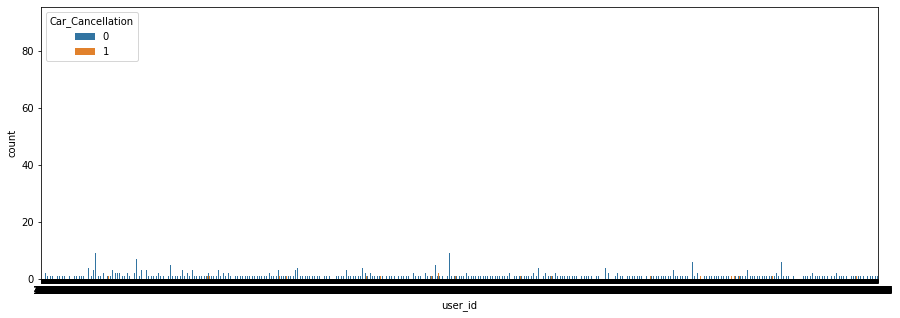

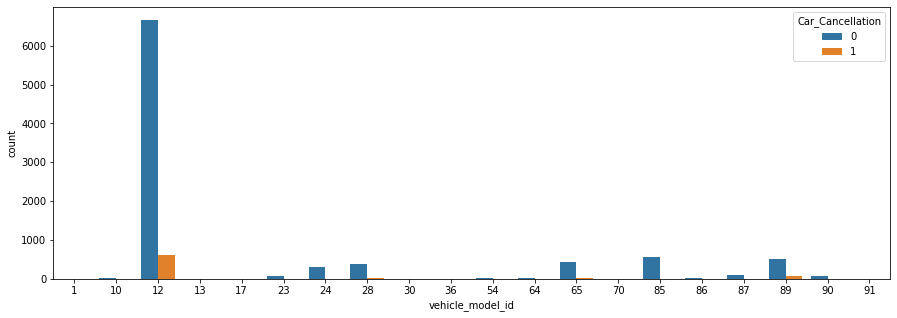

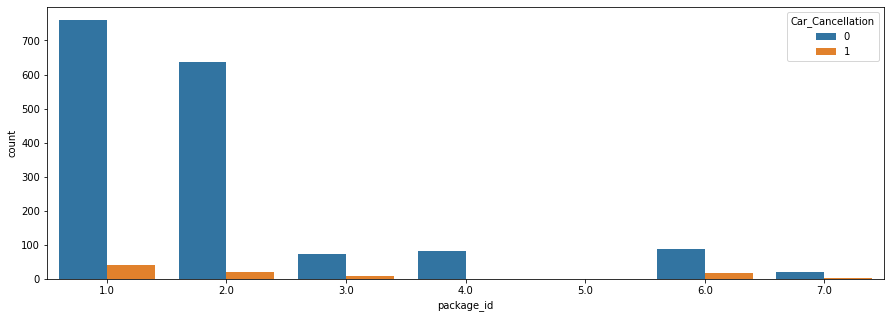

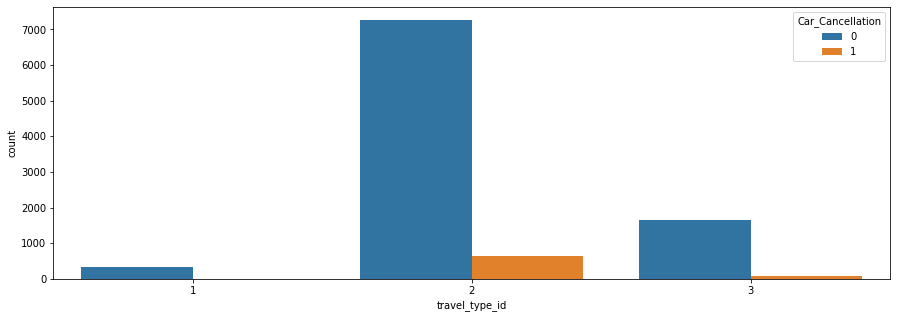

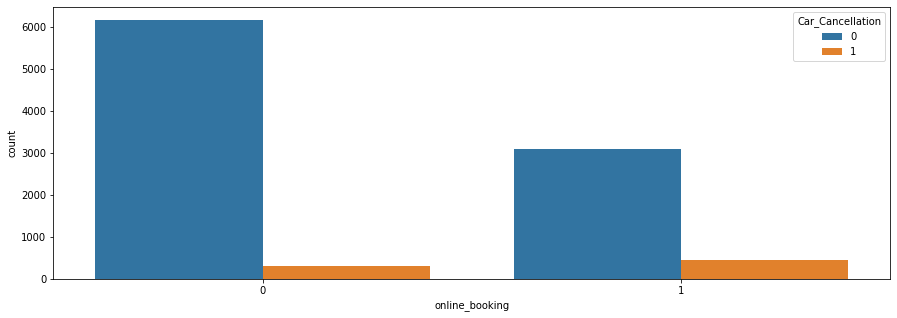

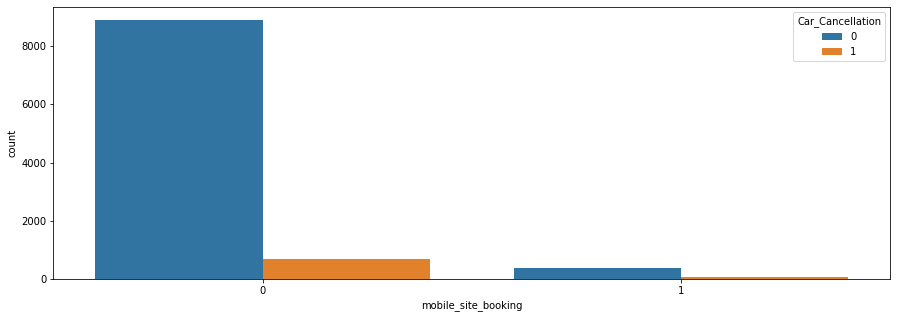

In [46]:
# Cateforical EDA
import seaborn as sns

cat_vars = ['user_id', 'vehicle_model_id', 'package_id', 'travel_type_id', 'online_booking', 'mobile_site_booking']
for col in cat_vars:
  plt.figure(figsize=(15,5))
  ax = sns.countplot(data = taxi_df, x = col, hue = 'Car_Cancellation')
  plt.show()

In [58]:
print('******************')
print('Car Cancellation Balance:')
print('******************')
print(taxi_df.Car_Cancellation.value_counts(dropna=False, normalize = True))
print('\n')
for col in cat_vars:
  print('******************')
  print('{} split:'.format(col))
  print('******************')
  p1 = taxi_df[(taxi_df.Car_Cancellation == 1)].groupby(col).size().reset_index(name='Car_Cancellation_Counts')
  p2 = taxi_df.groupby(col).size().reset_index(name='Total_Scheduled_Car_Counts')
  p1['Total_Scheduled_Car_Counts'] = p2['Total_Scheduled_Car_Counts']
  p1['Percent_Cancelled'] = p1['Car_Cancellation_Counts']/p2['Total_Scheduled_Car_Counts']
  p1['Percent_Cancelled_Total'] = (p1['Car_Cancellation_Counts']/p1['Car_Cancellation_Counts'].sum()) 
  p1['Percent_Scheduled_Total'] = (p2['Total_Scheduled_Car_Counts']/p2['Total_Scheduled_Car_Counts'].sum()) 
  p1['Cancelled_Index'] = (1.0*p1['Percent_Cancelled_Total']) / (1.0*p1['Percent_Scheduled_Total']) 
  print(p1.sort_values(by=['Cancelled_Index']))
  print('\n')

******************
Car Cancellation Balance:
******************
0    0.9257
1    0.0743
Name: Car_Cancellation, dtype: float64


******************
user_id split:
******************
     user_id  Car_Cancellation_Counts  Total_Scheduled_Car_Counts  \
0         16                        0                           1   
4530   37147                        0                           1   
4529   37146                        0                           1   
4528   37144                        0                           2   
4527   37140                        0                           1   
...      ...                      ...                         ...   
1543   24588                        1                           1   
5625   41759                        1                           1   
6571   46191                        1                           1   
2550   28735                        3                           3   
3108   31167                        3                      

In [41]:
taxi_df.groupby('travel_type_id').Car_Cancellation.nunique()

travel_type_id
1    2
2    2
3    2
Name: Car_Cancellation, dtype: int64

---
**Question 3.4 Answer:**<br>
ugh
---

---
## Question 4
Fit several predictive models of your choice. Do they provide information on how the predictor variables relate to cancellations? (15 Points)


---
**Question 4 Answer:**<br>
ugh
---

---
## Question 5
Report the predictive performance of your model in terms of error rates (the confusion matrix). How well does the model perform? Can the model be used in practice? (10 Points)

---
**Question 5 Answer:**<br>
ugh
---

---
## Question 6
Examine the predictive performance of your model in terms of ranking (lift). How well does the model perform? Can the model be used in practice? (10 Points)


---
**Question 6 Answer:**<br>
ugh
---

---
## Question 7
Briefly explain, in two to three paragraphs, the business objective, the data mining models used, why they were used, the model results, and your recommendations to your non-technical stakeholder team. (10 Points)


---
**Question 7 Answer:**<br>
ugh
---